# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [7]:
path = untar_data(URLs.PETS)/'images'
path.ls()

[PosixPath('/storage/oxford-iiit-pet/images/yorkshire_terrier_106.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/samoyed_53.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/keeshond_190.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Maine_Coon_43.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Persian_173.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/shiba_inu_29.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/British_Shorthair_103.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Birman_100.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/pomeranian_34.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/newfoundland_194.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Russian_Blue_28.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Russian_Blue_41.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/Persian_175.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/samoyed_194.jpg'),
 PosixPath('/storage/oxford-iiit-pet/images/saint_bernard_12.jpg'),
 PosixPath('/

## Data augmentation

In [8]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [9]:
doc(get_transforms)

In [10]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [11]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [12]:
data = get_data(224, bs, 'zeros')

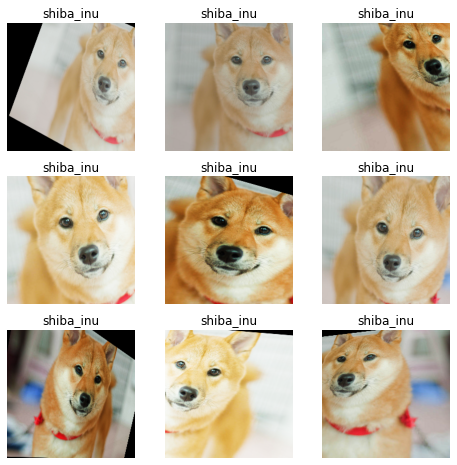

In [13]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [14]:
data = get_data(224,bs)

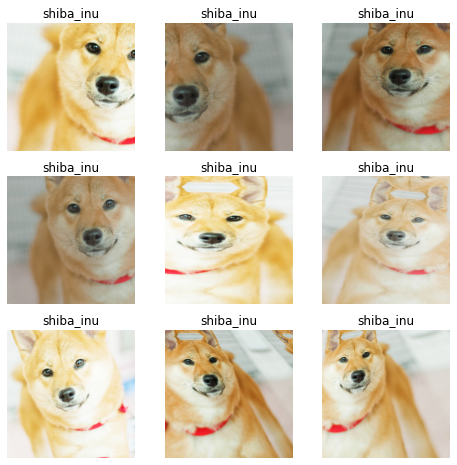

In [19]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [20]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [21]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.642769,0.363156,0.089310,00:25
1,0.956195,0.309200,0.091340,00:24
2,0.723603,0.280719,0.083897,00:24


In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.571405,0.276109,0.079838,00:34
1,0.536181,0.268930,0.068336,00:35


In [23]:
data = get_data(352,bs)
learn.data = data

In [24]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.512823,0.253375,0.063599,01:21
1,0.474980,0.253673,0.064276,01:17


In [25]:
learn.save('352')

## Convolution kernel

In [26]:
data = get_data(352,16)

In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category 33

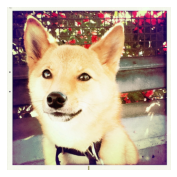

In [31]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [32]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [33]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [34]:
k.shape

torch.Size([1, 3, 3, 3])

In [35]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [36]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [37]:
edge = F.conv2d(t[None], k)

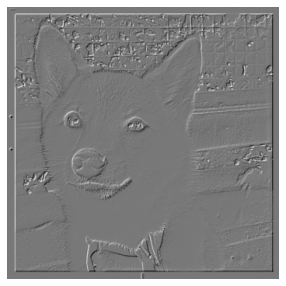

In [38]:
show_image(edge[0], figsize=(5,5));

In [39]:
data.c

37

In [40]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [41]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [91]:
m = learn.model.eval();
print(m[1])

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=True)
  (9): BatchNorm1d(37, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
)


In [43]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [44]:
from fastai.callbacks.hooks import *

In [45]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [46]:
hook_a,hook_g = hooked_backward()

torch.Size([512, 11, 11])

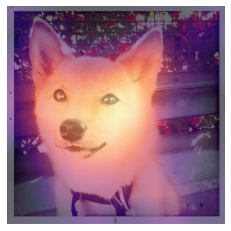

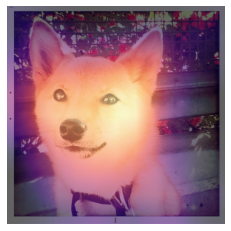

In [74]:
acts  = hook_a.stored[0].cpu()

show_heatmap(acts.std(0))
show_heatmap(acts.mean(0))

acts.shape



In [48]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [49]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

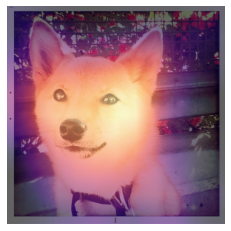

In [50]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [51]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [52]:
mult = (acts*grad_chan[...,None,None]).mean(0)

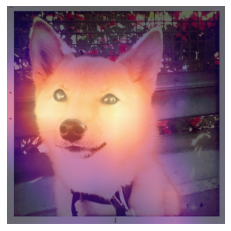

In [54]:
show_heatmap(mult)

In [76]:
fn = path/'../Thinking-of-getting-a-cat.png' #Replace with your own image


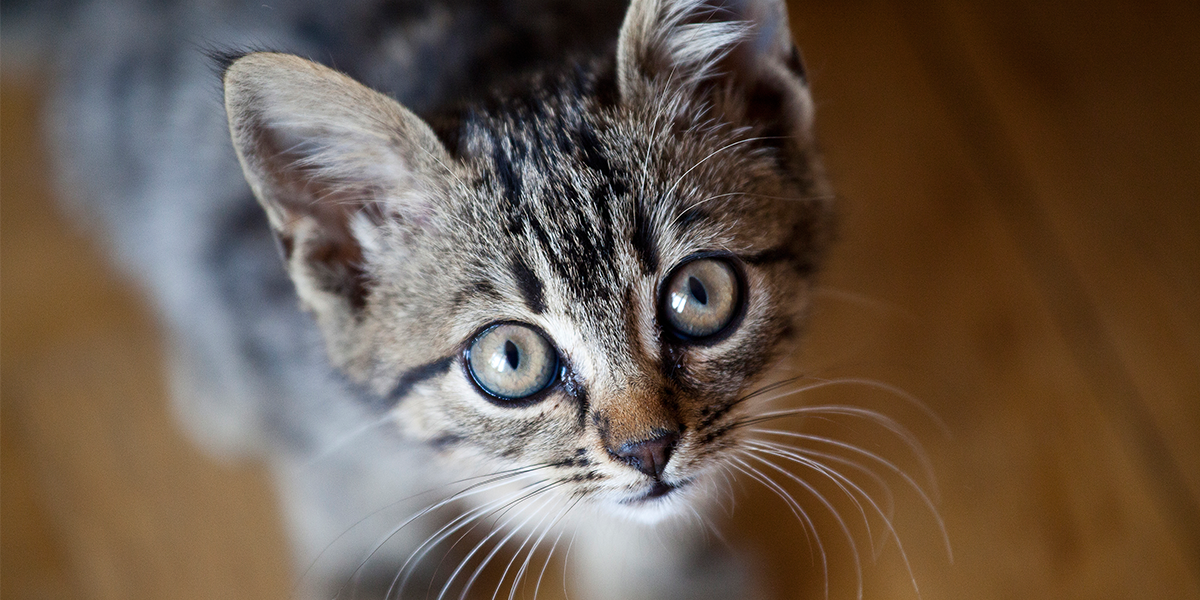

In [77]:
x = open_image(fn); x

In [78]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [79]:
hook_a,hook_g = hooked_backward()

In [80]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

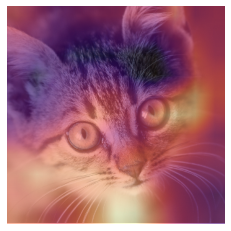

In [81]:
show_heatmap(mult)

In [82]:
data.classes[0]

'Abyssinian'

In [83]:
hook_a,hook_g = hooked_backward(0)

In [84]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

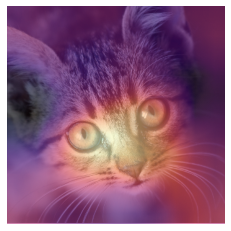

In [85]:
show_heatmap(mult)

## fin